<span style="color:red">Abgegeben von (Name, Vorname):</span> 
Umlauf, Béla

# Projektbeschreibung: Sentiment Analysis von Tweets

Das Projekt besteht darin, einen Klassifikator zu entwickeln, der entscheiden kann, ob eine Tweet wie `GREAT GAME GIRLS!! On to districts Monday at Fox!! Thanks to the fans for coming out :)` positiv, negativ oder neutral/objektiv ist. 

## Daten

Für die Entwicklung des Klassifikators nutzen wir die Daten des SemEval 2013 Task 2b, ein Korpus mit 14882 annotierten Tweets: 

- Informationen zum Korpus: https://aclanthology.org/S13-2052/
- Corpus als zip-Datei: [semeval2013.zip](https://moodle.zdv.uni-tuebingen.de/pluginfile.php/269639/mod_assign/introattachment/0/semeval2013.zip?forcedownload=1)

Bitte entpacken Sie das Corpus im Ordner ihres Notebooks.

Das Format des Corpus ist denkbar einfach: Jede Zeile enthält einen Tweet, wobei das Tag am Zeilenanfang steht und vom Text durch einen Tabulator getrennt ist:

    264224316193902592	positive	GREAT GAME GIRLS!! On to districts Monday at Fox!! Thanks to the fans for coming out :)
    

## Teilaufgaben

Bearbeiten Sie die Folgenden Teilaufgaben und verwenden Sie dabei grundsätzlich **nur die in der Vorlesung verwendeten Python-Module**, insbesondere NLTK. Abweichungen müssen jeweils plausibel begründet werden.

- <span style="color:red">A1: </span> Lesen Sie die Daten ein, die bereits in Traings-, Entwicklungs- und Testdaten unterteilt sind, und reinigen Sie die Daten, falls nötig (z.B. hinsichtlich Unicode).
- <span style="color:red">A2: </span> Geben Sie eine Statistik über den Umfang der Datensplits und die Verteilung der Klassenlabel an. (Sind die Klassenlabel gleichmäßig über die Datensplits verteilt?)
- <span style="color:red">A3: </span> Implementieren Sie eine einfache, aber nicht zu niedrige Baseline und führen Sie eine Evaluierung anhand der Baseline durch!
- <span style="color:red">A4: </span> Implementieren Sie (mindestens) ein weiteres Verfahren, das sich von dem der Baseline wesentlich unterscheidet! 
- <span style="color:red">A5: </span> Untersuchen Sie die Nützlichkeit der linguistischen Features Stamm/Lemma und POS-Tag auf dem Dev-Daten. Können diese gewinnbringend eingesetzt werden?
- <span style="color:red">A6: </span> Führen Sie eine Evaluierung anhand der Testdaten für das zweite Verfahren durch!
- <span style="color:red">A7: </span> Fassen Sie die Ergebnisse zusammen und bewerten Sie diese kurz!

Bitte achten Sie auf eine durchgehende Dokumentation der Bearbeitungsschritte. Die Dokumentation sollte in der Art und Detailliertheit den Notebooks des Kurses entsprechen. D.h. die Erläuterung sollten vornehmlich in Markdown-Blöcken gemacht werden.

Viel Erfolg!

# Lösung

In [1]:
import pandas as pd
import nltk
import numpy as np

### <span style="color:red">  1.) Einlesen und Reinigen der Daten 
Zum Einlesen der .tsv Daten wird **pandas** verwendet, das wohl bekannteste python tool für Datenanalyse.  
Per `read_csv()` wird die Datei in ein Dataframe eingelesen und durch `sep='\t'` Tab getrennt. Wobei jeder Datensplit in einem eigenen Dataframe gespeichert ist. Des Weiteren wird ein Header hinzugefügt.

In [2]:
#Erhöt die Zeilenlänge für das Dataframe
pd.set_option('display.max_colwidth', None)

header = ["ID", "Label", "Tweet"]

train_data = pd.read_csv('semeval2013/twitter-2013train-A.txt',sep='\t',names=header, encoding='utf8')
dev_data = pd.read_csv('semeval2013/twitter-2013dev-A.txt',sep='\t',names=header, encoding='utf8')
test_data = pd.read_csv('semeval2013/twitter-2013test-A.txt',sep='\t',names=header, encoding='utf8')

#### Reinigen der Daten
Zunächst werden alle Unicodes richtig interpretiert und Hashtags, @ und Links aus den Tweets entfernt. 
Die verwendeten Regular expressions sind:  
- `r'\\u([0-9a-fA-F]{4})'`:     Alle Chars, die mit `/u` beginnen sowie 4 weitere Hexademizalzahlen, welche den Unicode ergeben  
- `r'http\S+|https\S+|www.\S+'`: Alle Links, die mit `http`, `https` oder `www` beginnen.  
-  `r'\@\w+|\#'`: Alle Hashtags und @, sowie die darauf Folgenden Wörter.  
   
Weiteres Cleaning wird eventuell im späteren Verlauf vorgenommen.  


In [3]:
import re

#Regex für Unicode
unicode_regex = r'\\u([0-9a-fA-F]{4})'

#Regex für Links
links_regex = r'http\S+|https\S+|www.\S+'

#Regex für @ und #
at_and_hasht = r'\@\w+|\#'

Die Funktionen `translate_unicode()` und `clean_tweet()` führen die Regex Befehle jeweils auf eine Zeile im Dataframe aus.

In [4]:
#Funktion, welche den Unicode aus dem Dataframe durch den entsprechenden Char ersetzt.
def translate_unicode(col):
    return re.sub(unicode_regex,  lambda m: chr(int(m.group(1), 16)), 
                  col.encode().decode('unicode-escape'))

#Entfernt @ und # aus den Tweets
def clean_tweet(col):
    col = re.sub(links_regex,"",col)
    col = re.sub(at_and_hasht,"",col)
    return col

Der `Train Split` **vor** dem cleaning:

In [5]:
train_data.head(5)

,ID,Label,Tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :)
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa and Johnny deal with him on Saturday.
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just hate Nick Diaz. can\u2019t wait for february.
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome can\u2019t deal with their missiles (keep talking like that and we may end up finding out)
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establish Ties with the Mullahs http://t.co/TZZzrrKa via @PJMedia_com No Barack Obama - Vote Mitt Romney


Die Funktionen `translate_unicode()` und `clean_tweet()` werden auf jeden Tweet im Dataframe `train_data` angewandt.

In [6]:
train_data['Tweet'] = train_data['Tweet'].apply(clean_tweet)
train_data['Tweet'] =  train_data['Tweet'].apply(translate_unicode).str.replace('\\','' , regex=True)

C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\m'
  col.encode().decode('unicode-escape'))
C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\_'
  col.encode().decode('unicode-escape'))
C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\/'
  col.encode().decode('unicode-escape'))
C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\ '
  col.encode().decode('unicode-escape'))


Der `Train Split` **nach** dem cleaning:

In [7]:
train_data.head(5)

,ID,Label,Tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I’m going to Chapel Hill on Sat. :)
1,263405084770172928,negative,"Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday."
2,262163168678248449,negative,"its not that I’m a GSP fan, i just hate Nick Diaz. can’t wait for february."
3,264249301910310912,negative,Iranian general says Israel’s Iron Dome can’t deal with their missiles (keep talking like that and we may end up finding out)
4,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ties with the Mullahs via No Barack Obama - Vote Mitt Romney"


Reinigen der anderen beiden Datensplits.

In [8]:
dev_data['Tweet'] = dev_data['Tweet'].apply(clean_tweet)
dev_data['Tweet'] =  dev_data['Tweet'].apply(translate_unicode).str.replace('\\','' , regex=True)

test_data['Tweet'] = test_data['Tweet'].apply(clean_tweet)
test_data['Tweet'] =  test_data['Tweet'].apply(translate_unicode).str.replace('\\','' , regex=True)

C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\ '
  col.encode().decode('unicode-escape'))
C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\m'
  col.encode().decode('unicode-escape'))
C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\i'
  col.encode().decode('unicode-escape'))
C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\('
  col.encode().decode('unicode-escape'))
C:\Users\belau\AppData\Local\Temp\ipykernel_11004\419590767.py:4: DeprecationWarning: invalid escape sequence '\o'
  col.encode().decode('unicode-escape'))


### <span style="color:red"> 2.) Statisik  
Im Folgenden wird die Statistik über den Umfang der Datensplits, sowie die Verteilung der Label vorgenommen. Für das Visualisieren der Statistik wird das Modul **matplotlib** verwendet.

In [9]:
from matplotlib import pyplot as plt

#### Umfang der Datensplits  
Um die größe der Datensplits zu untersuchen, wird die Länge der Dataframes mit Barcharts visualisiert.

[9684, 1654, 3547]


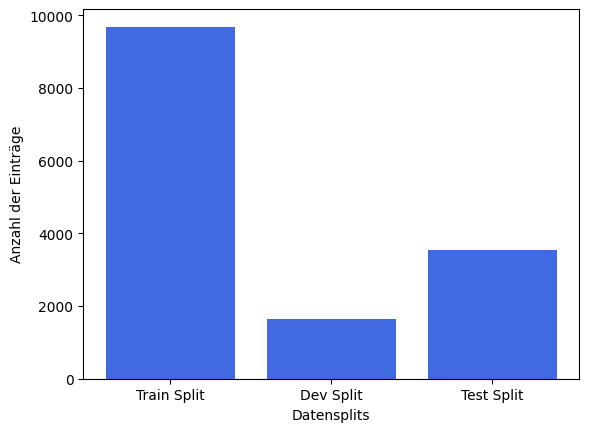

In [10]:
dfs = [train_data, dev_data, test_data]

data_lens = [len(df.index) for df in dfs]
print(data_lens)

df_names = ["Train Split", "Dev Split", "Test Split"]

plt.bar(df_names, data_lens, color="royalblue")
plt.xlabel("Datensplits")
plt.ylabel("Anzahl der Einträge")
plt.show()

Wir sehen, dass der `Train Split` deutlich größer als die beiden anderen Splits ausfällt. Er ist mit 9684 Einträgen etwa doppelt so groß wie die beiden anderen zusammen. Wobei der `Dev Split` mit 1654 Einträgen etwa doppelt so klein wie der `Test Split` mit 3547 Einträgen ist.

#### Verteilung der Klassenlabel  
Die Verteilung der Klassenlabel in den Datensplits wird ebenfalls per Barcharts visualisiert. Dazu werden die Anzahl der jeweiligen Label pro Split in Sublisten gespeichert und anschließend visualisiert.

In [11]:
labels = ['positive', 'negative', 'neutral']

label_distr = []
for label in labels:
    tmp = []
    for df in dfs:
        tmp.append((df['Label'] == label).sum())
    label_distr.append(tmp)

print(label_distr)

[[3640, 575, 1475], [1458, 340, 559], [4586, 739, 1513]]


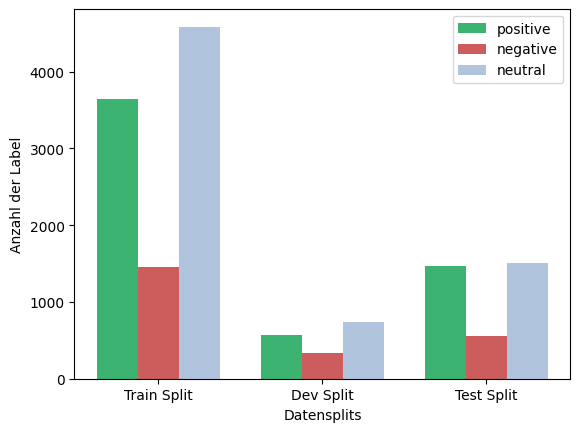

In [12]:
X = np.arange(3)
plt.bar(X + 0.00, label_distr[0], color = 'mediumseagreen', width = 0.25)
plt.bar(X + 0.25, label_distr[1], color = 'indianred', width = 0.25)
plt.bar(X + 0.50, label_distr[2], color = 'lightsteelblue', width = 0.25)
plt.xticks(X + 0.25, df_names)
plt.xlabel("Datensplits")
plt.ylabel("Anzahl der Label")
plt.legend(labels)
plt.show()

 Es ist erkennbar, dass die Verteilung der Label über die Splits relativ ähnlich ist. In jedem Datensplit gibt es deutlich mehr positive und neutrale als negative Label, wobei der Unterschied im Fall von `Dev Split` geringer ist. Des Weiteren lässt sich feststellen, dass es etwas mehr neutrale als positive Label gibt. Dies wird besonders deutlich im Fall von `Train Split`.

### Pre-Processing  

Zunächst werden die Tweets tokenisiert und in einer neuen Spalte `df['token_tweets']` im Dataframe gespeichert. Dafür wird der `TweetTokenizer()` von nltk verwendet. Dieser bietet sich hier besonders gut an. 

In [13]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

train_data['token_tweets'] = train_data['Tweet'].apply(lambda x: tokenizer.tokenize(x))
train_data.head(5)

,ID,Label,Tweet,token_tweets
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I’m going to Chapel Hill on Sat. :),"[Gas, by, my, house, hit, $, 3.39, !, !, !, I, ’, m, going, to, Chapel, Hill, on, Sat, ., :)]"
1,263405084770172928,negative,"Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday.","[Theo, Walcott, is, still, shit, ,, watch, Rafa, and, Johnny, deal, with, him, on, Saturday, .]"
2,262163168678248449,negative,"its not that I’m a GSP fan, i just hate Nick Diaz. can’t wait for february.","[its, not, that, I, ’, m, a, GSP, fan, ,, i, just, hate, Nick, Diaz, ., can, ’, t, wait, for, february, .]"
3,264249301910310912,negative,Iranian general says Israel’s Iron Dome can’t deal with their missiles (keep talking like that and we may end up finding out),"[Iranian, general, says, Israel, ’, s, Iron, Dome, can, ’, t, deal, with, their, missiles, (, keep, talking, like, that, and, we, may, end, up, finding, out, )]"
4,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ties with the Mullahs via No Barack Obama - Vote Mitt Romney","[Tehran, ,, Mon, Amour, :, Obama, Tried, to, Establish, Ties, with, the, Mullahs, via, No, Barack, Obama, -, Vote, Mitt, Romney]"


Nun werden Stopwörter und Satzzeichen entfernt, da diese für die weitere Analyse nicht relevant sind. Wobei die Satztzeichen durch ein Apostroph erweitert werden, da diese beim Dekodieren der Unicodes erstellt wurden.


In [14]:
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))

punctuation = string.punctuation
punctuation = punctuation + '’'

train_data['token_tweets'] = train_data['token_tweets'].apply(lambda x: [word for word in x if word.lower() not in stop_words and word not in punctuation]) 
train_data.head(5)

,ID,Label,Tweet,token_tweets
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I’m going to Chapel Hill on Sat. :),"[Gas, house, hit, 3.39, going, Chapel, Hill, Sat, :)]"
1,263405084770172928,negative,"Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday.","[Theo, Walcott, still, shit, watch, Rafa, Johnny, deal, Saturday]"
2,262163168678248449,negative,"its not that I’m a GSP fan, i just hate Nick Diaz. can’t wait for february.","[GSP, fan, hate, Nick, Diaz, wait, february]"
3,264249301910310912,negative,Iranian general says Israel’s Iron Dome can’t deal with their missiles (keep talking like that and we may end up finding out),"[Iranian, general, says, Israel, Iron, Dome, deal, missiles, keep, talking, like, may, end, finding]"
4,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ties with the Mullahs via No Barack Obama - Vote Mitt Romney","[Tehran, Mon, Amour, Obama, Tried, Establish, Ties, Mullahs, via, Barack, Obama, Vote, Mitt, Romney]"


Das Pre-Processing für die beiden anderen Dataframes:


In [15]:
dev_data['token_tweets'] = dev_data['Tweet'].apply(lambda x: tokenizer.tokenize(x))
dev_data['token_tweets'] = dev_data['token_tweets'].apply(lambda x: [word for word in x if word.lower() not in stop_words and word not in punctuation])

test_data['token_tweets'] = test_data['Tweet'].apply(lambda x: tokenizer.tokenize(x))
test_data['token_tweets'] = test_data['token_tweets'].apply(lambda x: [word for word in x if word.lower() not in stop_words and word not in punctuation])

### <span style="color:red"> 3.) Baseline  
Im Folgenden wird die Baseline der Sentiment Analyse erstellt und evaluiert.  


Für den Baseline Klassifizierer werden die Wörter in den Tweets zunächst nach positiven, neutralen und negativen Tweets sortiert.

In [16]:

# Alle Wörter der als positive gelabelten Tweets:
positive_words = [word for tweet in train_data[train_data['Label'] == 'positive']['token_tweets'] for word in tweet]
# Analog für neutrale Tweets
neutral_words = [word for tweet in train_data[train_data['Label'] == 'neutral']['token_tweets'] for word in tweet]
# Analog für negative Tweets
negative_words = [word for tweet in train_data[train_data['Label'] == 'negative']['token_tweets'] for word in tweet]

print(positive_words[:5])
print(neutral_words[:5])
print(negative_words[:5])


['Gas', 'house', 'hit', '3.39', 'going']
['Tehran', 'Mon', 'Amour', 'Obama', 'Tried']
['Theo', 'Walcott', 'still', 'shit', 'watch']


#### Häufigkeitsverteilung  
Für jede Wortliste wird nun eine Häufigkeitsverteilung erstellt und Wörter, welche in mehreren Listen vorkommen entfernt, bzw. ihre Frequenz auf 0 gesetzt. Für die weitere Feature Extraction werden die 500 häufigsten Wörter aller Verteilungen (`top_pos`, `top_neu`, `top_neg`) verwendet.

In [17]:
#Wörter, die in allen 3 Listen auftauchen
common_set = set(positive_words) & set(negative_words) & set(neutral_words)

# Entferne redundante Wörter aus allen 3 Listen
positive_words = [word for word in positive_words if word not in common_set]
neutral_words = [word for word in neutral_words if word not in common_set]
negative_words = [word for word in negative_words if word not in common_set]

# Häufigkeitsverteilungen für alle 3 Listen
pos_freq_dist = nltk.FreqDist(positive_words)
neu_freq_dist = nltk.FreqDist(neutral_words)
neg_freq_dist = nltk.FreqDist(negative_words)

#Die Häufigkeit für redundante Wörter wird auf 0 gesetzt
for word in common_set:
    pos_freq_dist[word] = 0
    neu_freq_dist[word] = 0
    neg_freq_dist[word] = 0

# Die 500 häufigsten Einträge in allen Verteilungen
top_pos = [word.lower() for word, _ in pos_freq_dist.most_common(500)]
top_neu = [word.lower() for word, _ in neu_freq_dist.most_common(500)]
top_neg = [word.lower() for word, _ in neg_freq_dist.most_common(500)]

print(top_pos[:5])
print(top_neu[:5])
print(top_neg[:5])

['amazing', 'come', ':-)', 'favorite', 'thank']
['come', 'club', '15', 'watch', '26']
['fuck', 'worse', 'stupid', 'sucks', 'leaves']


#### Feature Extraction  
Die `extract_features()` Funktion bestimmt 6 verschiedene Features in einem Dictonary:
- `features[f'contains positive]` Checkt jedes Wort im Tweet ob es ein Wort aus `top_pos` enthält 
- `features[f'contains negative]` Checkt jedes Wort im Tweet ob es ein Wort aus `top_neg` enthält
- `features[f'contains neutral]` Checkt jedes Wort im Tweet ob es aus `top_neu` enthält
- `features["pos_wordcount"]` zählt für jeden Tweet wie viele Wörter aus `top_pos` enthalten sind
- `features["neg_wordcount"]` zählt für jeden Tweet wie viele Wörter aus `top_neg` enthalten sind
- `features["neu_wordcount"]` zählt für jeden Tweet wie viele Wörter aus `top_neu` enthalten sind  

Wobei die Anzahl der Wörter aus `top_pos`, ``top_neg`` und `top_neu` über die Variable `top_word_count` geändert werden kann.

In [18]:
def extract_features(tweet,top_word_count):
    features = {}
    
    pos_count = 0
    neg_count = 0
    neu_count = 0
    
    for word in top_pos[:top_word_count]:
        features[f'contains positive({word})'] = (word in set(tweet))
    for word in top_neg[:top_word_count]:
        features[f'contains negative({word})'] = (word in set(tweet))
    for word in top_neu[:top_word_count]:
        features[f'contains neutral({word})'] = (word in set(tweet))
    
    for word in set(tweet):
        if word.lower() in top_pos[:top_word_count]:
            pos_count +=1
        if word.lower() in top_neu[:top_word_count]:
            neu_count +=1
        if word.lower in top_neg[:top_word_count]:
            neg_count += 1

    features["pos_wordcount"] = pos_count
    features["neu_wordcount"] = neu_count
    features["neg_wordcount"] = neg_count
        
    return features

#### Evaluation  

`extract_features()` wird auf jeden Tweet in `df['token_tweets]` im Train und Test Dataframe angewendet, wobei die Label aus `df['Label']`beibehalten werden. Es werden für verschiedene Längen der häufigsten positiven/negativen/neutralen Wörtern jeweils ein `train_set` und ein `test_set` erstellt.
  
Jedes Element dieser Sets besteht aus einem Tuple, deren erstes Element die Features aus `extract_features()` und das zweite jeweils das vordefinierten Label aus `df['Label']` beinhalten.

Für die Evaluation wird ein **Naive-Bayes-Klassifizierer** verwendet, welcher mit `train_set` trainiert und anschließend mit `test_set` getestet wird.

In [19]:
from nltk import NaiveBayesClassifier
accuracies_baseline = []
for word_count in [50, 100, 250, 500]:

    train_set = [(extract_features(tweet, word_count),label) for (tweet, label) in zip(train_data.token_tweets, train_data.Label)]
    test_set = [(extract_features(tweet, word_count),label) for (tweet, label) in zip(test_data.token_tweets, test_data.Label)]

    classifier = NaiveBayesClassifier.train(train_set)

    accuracy_baseline = nltk.classify.accuracy(classifier, test_set)
    accuracies_baseline.append(accuracy_baseline)
    print(f"Accuracy when featuring {word_count} most frequent words is at : ",accuracy_baseline)

Accuracy when featuring 50 most frequent words is at :  0.5111361714124613
Accuracy when featuring 100 most frequent words is at :  0.5243868057513391
Accuracy when featuring 250 most frequent words is at :  0.5348181561883282
Accuracy when featuring 500 most frequent words is at :  0.5824640541302509


Es lässt sich erkennen, dass mit mehr Top Wörtern ein besseres Ergebnis erziehlt werden kann. Jedoch ist das Ergebnis mit 58 % bei den 500 häufigsten positiven/negativen/neutralen Wörtern immer noch sehr bescheiden.  

Im Folgenden wird ein weiteres Verfahren getestet, um die Accuracy zu verbessern.

### <span style="color:red"> 4.) Verbessertes Sentiment Analysis Verfahren 

Für ein weiteres Verfahren werden Word Embedding per `Word2Vec` des Moduls `gensim` für die Feature Extraction verwendet. Zunächst wird das Model auf Basis **aller** tokenisierten Tweets erstellt und gespeichert.  
  
Es werden Train-, Dev-, und Testsplit verwendet, damit ein möglichst großes Vokabular vorhanden ist. Dafür werden die tokenisierten Tweets der jeweiligen Splits per `pd.concat()` konkatiniert.  

Die größe der Wordvektoren wird auf 300 gesetzt, ähnlich wie im Vektoren-Lexikon von Google.

In [20]:
#Konkatinieren der tokenisierten Tweets

all_token_tweets = [train_data['token_tweets'], test_data['token_tweets'], dev_data['token_tweets']]
merged_token_tweets = pd.concat(all_token_tweets)

merged_token_tweets.shape

(14885,)

Erstellen des Word2Vec Models:

In [21]:
from gensim.models import Word2Vec
VECTOR_SIZE = 300
#Erstellen des Models
w2v_model = Word2Vec(merged_token_tweets,
                                   vector_size=VECTOR_SIZE, 
                                   window=5,
                                   min_count=1,
                                   workers = 3,
                                   sg = 1)
#Speichern des Modells
w2v_model.save('tweets.embedding')

Im Anschluss wird das erstellte Model mit `w2v_model.train()` trainiert:

In [22]:
w2v_model = Word2Vec.load('tweets.embedding')
w2v_model.train(merged_token_tweets, total_examples= len(merged_token_tweets), epochs=20)

(3402575, 3565580)

In [23]:
print(f"Anzahl der Wortformen beträgt: {len(w2v_model.wv)}")

w2v_model.wv.most_similar(positive='Obama',topn=5)

Anzahl der Wortformen beträgt: 30888


[('Romney', 0.7593239545822144),
 ('Barack', 0.7407937049865723),
 ('proposes', 0.7326763272285461),
 ('Boehner', 0.7305948138237),
 ('Hussein', 0.6800503134727478)]

Alternativ wird das votrainierte Word2Vec Lexikon von Google aus dem Notebook 12 verwendet.

In [24]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

#### Feature Extraction

Die Funktion `word_vector()` erstellt einen Wortvektor für einen bestimmten Tweet auf Basis des trainierten Models `w2v_model`.

In [25]:
def word_vector(tweet, size):

    #Initialisieren des Wortvektor
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet:
        try:
            vec += w2v_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError: #Token wurde nicht gefunden
                         
            continue
    if count != 0:
        vec /= count #normalisieren des Vektors
    return vec

Parallel dazu erstellt `google_word_vector()` einen Wortvektor aus Basis des Google Lexikons.

In [26]:
def google_word_vector(tweet, size):

    #Initialisieren des Wortvektor
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet:
        try:
            vec += wv[word].reshape((1, size))
            count += 1.
        except KeyError: #Token wurde nicht gefunden
                         
            continue
    if count != 0:
        vec /= count #normalisieren des Vektors
    return vec

Für die Feature Extraction wird die Funktion `w2v_extract_features()` verwendet.  

 Es werden Wortvektoren auf Basis der tokenisierten Tweets aus `data['token_tweets']` erstellt und in einer Matrix `wordvec_arrays` gespeichert und schlussendlich in ein Dataframe `wordvec_df` verpackt.  
 
Die Sentiment-Label aus `data['Label']` werden konkatiniert. Mit dem Boolean `is_google` kann entschieden werden, welche Wortvektor Funktion verwendet wird.

In [27]:
def w2v_extract_features(data, length, is_google):
    
    #Initalisieren der Wordvektor-Matrix
    wordvec_arrays = np.zeros((len(data['token_tweets']), length))

    #Matrix wird mit Wordvektoren gefüllt
    for i in range(len(data['token_tweets'])):

        if is_google:
            #Wortvektoren auf Basis des Google Models
            wordvec_arrays[i,:] = google_word_vector(data['token_tweets'][i], length)

        else:
            #Wortvektoren auf basis des selbst trainierten Models
            wordvec_arrays[i,:] = word_vector(data['token_tweets'][i], length)

    #Erstellen des Dataframes
    wordvec_df = pd.DataFrame(wordvec_arrays)

    #Konkatinieren der Label
    wordvec_df_with_labels = pd.concat([wordvec_df, data['Label']], axis=1)
    return wordvec_df_with_labels

#### Train und Test Set

Nun werden Train und Test Dataframes erstellt. Einmal für das selbst trainierte Model und einmal auf Basis des vortrainierten Google Models.

In [28]:
#Test und Train Dataframe auf Basis des trainierten Models
train_wordvec_df_with_labels = w2v_extract_features(train_data, VECTOR_SIZE, is_google=False)
test_wordvec_df_with_labels = w2v_extract_features(test_data, VECTOR_SIZE, is_google=False)

#Test und Train Dataframe auf Basis des Google Lexikons
google_train_wordvec_df_with_labels = w2v_extract_features(train_data, VECTOR_SIZE, is_google=True)
google_test_wordvec_df_with_labels = w2v_extract_features(test_data, VECTOR_SIZE, is_google=True)

Jede Zeile im Train und Test Dataframe besteht nun aus den 300 Features des Tweet-Wortvektors und dem passenden Label:

In [29]:
train_wordvec_df_with_labels.head(5)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Label
0,-0.188363,0.044593,0.100434,0.259165,-0.052016,-0.374078,-0.000308,0.354792,0.330590,-0.287274,...,0.242554,-0.088605,0.142085,0.263226,0.163608,-0.173197,-0.114157,0.120434,-0.032656,positive
1,0.178456,0.292390,0.023283,-0.093870,0.237932,-0.280149,0.223168,0.282662,-0.144121,0.052211,...,0.415813,-0.098451,0.119488,0.002041,0.157508,0.057841,0.003562,0.190191,-0.237399,negative
2,0.094433,0.391684,-0.023818,0.125311,-0.183807,-0.064948,0.338421,-0.053075,-0.034775,-0.133316,...,0.186776,-0.039508,-0.055037,0.165965,0.181441,0.053882,-0.098332,0.141128,0.005548,negative
3,0.020434,0.210908,0.071782,-0.079606,0.004344,-0.238447,0.081266,0.215930,0.069858,-0.061298,...,0.198510,0.090091,-0.084991,-0.031249,0.237559,0.022044,-0.060763,0.316439,-0.074157,negative
4,0.004129,0.263781,0.136963,0.050277,0.192543,-0.180275,0.218149,0.346590,0.061969,-0.035911,...,0.175340,-0.055211,-0.123395,0.198778,0.144404,0.141386,-0.169822,0.160508,-0.117805,neutral


Nun werden mit Hilfe der Funktion `row_to_tupel()` erneut neue `train_set` und `test_set` für Aufgabe 6 erstellt. Sie bestehen aus Tupeln, welche als erstes Element den Feature Wordvektor aus dem Wordvektor Dataframe und als zweites Element das Label haben.

In [30]:
#Funktion, welche aus einer Reihe im Dataframe ein Tuple aus Feature Wordvektor und Label erstellt

def row_to_tuple(row):
   features = {}
   for i, value in enumerate(row[:-1]):
       features[f"feature_{i}"] = value
   return (features, row['Label'])

Für beide Modelle werden jeweils ein Train und ein Test Set erstellt.

In [31]:
#Train und Test Set für das selbsttrainierte Model
train_set_model = [row_to_tuple(row) for _, row in train_wordvec_df_with_labels.iterrows()]
test_set_model = [row_to_tuple(row) for _, row in test_wordvec_df_with_labels.iterrows()]

#Train und Test Set für das Google Model
train_set_google = [row_to_tuple(row) for _, row in google_train_wordvec_df_with_labels.iterrows()]
test_set_google = [row_to_tuple(row) for _, row in google_test_wordvec_df_with_labels.iterrows()]

train_set_model[0]

({'feature_0': -0.18836285091108745,
  'feature_1': 0.04459305071375436,
  'feature_2': 0.10043414268228743,
  'feature_3': 0.25916521064937115,
  'feature_4': -0.052015813843657575,
  'feature_5': -0.37407831102609634,
  'feature_6': -0.00030801041672627133,
  'feature_7': 0.3547915418942769,
  'feature_8': 0.3305904045701027,
  'feature_9': -0.2872738349768851,
  'feature_10': 0.12294483308990796,
  'feature_11': -0.058204936484495796,
  'feature_12': -0.03631905673278703,
  'feature_13': 0.15118388541870648,
  'feature_14': 0.022578960491551295,
  'feature_15': -0.009590681849254502,
  'feature_16': 0.03930699701110522,
  'feature_17': -0.2016555848531425,
  'feature_18': 0.20344232105546528,
  'feature_19': -0.017368490083350077,
  'feature_20': -0.16547716243399513,
  'feature_21': -0.09068352604905765,
  'feature_22': 0.13654424167341656,
  'feature_23': 0.10534591144985622,
  'feature_24': 0.03665490308776498,
  'feature_25': -0.12475849398308331,
  'feature_26': -0.196216090685

### <span style="color:red"> 5.) Nützlichkeit von Lemmatisierung und POS-Tags  

Im Folgenden wird an mit Hilfe des Dev Splits analysiert, ob Lemmatisieren und POS-Tagging die Accuracy der Sentiment Analyse verbessern können.

#### POS-Tagging

Zunächst wird POS-Tagging auf die Wörter in den Tweets angewendet. Hierfür wird der standart POS-Tagger `pos_tag()` von nltk verwendet, da das Erstellen eines eigenen POS-Taggers ohne passendes Training- und Testdatenset nicht möglich ist.

In [32]:
from nltk import DefaultTagger
from nltk import UnigramTagger
from nltk import NgramTagger
from nltk import pos_tag

train_data['tagged_tweet'] = train_data['token_tweets'].apply(lambda x: pos_tag(x))
dev_data['tagged_tweet'] = dev_data['token_tweets'].apply(lambda x: pos_tag(x))
test_data['tagged_tweet'] = test_data['token_tweets'].apply(lambda x: pos_tag(x))

train_data.head(5)

,ID,Label,Tweet,token_tweets,tagged_tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I’m going to Chapel Hill on Sat. :),"[Gas, house, hit, 3.39, going, Chapel, Hill, Sat, :)]","[(Gas, NNP), (house, NN), (hit, VBD), (3.39, CD), (going, VBG), (Chapel, NNP), (Hill, NNP), (Sat, NNP), (:), NN)]"
1,263405084770172928,negative,"Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday.","[Theo, Walcott, still, shit, watch, Rafa, Johnny, deal, Saturday]","[(Theo, NNP), (Walcott, NNP), (still, RB), (shit, VBD), (watch, JJ), (Rafa, NNP), (Johnny, NNP), (deal, NN), (Saturday, NNP)]"
2,262163168678248449,negative,"its not that I’m a GSP fan, i just hate Nick Diaz. can’t wait for february.","[GSP, fan, hate, Nick, Diaz, wait, february]","[(GSP, NNP), (fan, NN), (hate, NN), (Nick, NNP), (Diaz, NNP), (wait, VBP), (february, JJ)]"
3,264249301910310912,negative,Iranian general says Israel’s Iron Dome can’t deal with their missiles (keep talking like that and we may end up finding out),"[Iranian, general, says, Israel, Iron, Dome, deal, missiles, keep, talking, like, may, end, finding]","[(Iranian, JJ), (general, JJ), (says, VBZ), (Israel, NNP), (Iron, NNP), (Dome, NNP), (deal, NN), (missiles, NNS), (keep, VB), (talking, VBG), (like, IN), (may, MD), (end, VB), (finding, VBG)]"
4,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ties with the Mullahs via No Barack Obama - Vote Mitt Romney","[Tehran, Mon, Amour, Obama, Tried, Establish, Ties, Mullahs, via, Barack, Obama, Vote, Mitt, Romney]","[(Tehran, NNP), (Mon, NNP), (Amour, NNP), (Obama, NNP), (Tried, NNP), (Establish, NNP), (Ties, NNP), (Mullahs, NNP), (via, IN), (Barack, NNP), (Obama, NNP), (Vote, NNP), (Mitt, NNP), (Romney, NNP)]"


#### Lemmatisieren

Nun müssen die POS-tagged Tweets aus den Daten Splits lemmatisiert werden. Dazu wird in jedem Split eine neue Spalte `df['lemma_tweet']` angelegt.  

Für das Lemmatisieren wird `lemmatize_tag()` verwendet. Die Funktion lemmatisiert mit Hilfe des `WordNetLemmatizer()` von nltk auf Basis des POS-Tags. Dies wird jeweils auf jeden Tweet im Dataframe angewand.

In [33]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

# Funktion aus Notebook 02, um passend zum POS-Tag zu Lemmatisieren
def lemmatize_tag(t_word):
        if t_word[1].startswith('V'):
            return wnl.lemmatize(t_word[0],pos='v') 
        elif t_word[1].startswith('J'):
            return wnl.lemmatize(t_word[0],pos='a')
        elif t_word[1].startswith('R'):
            return wnl.lemmatize(t_word[0],pos='r')
        else:
            return wnl.lemmatize(t_word[0])

In [34]:
#Lemmatisieren des Train Splits
train_data['lemma_tweet'] = train_data['tagged_tweet'].apply(lambda x: [lemmatize_tag(word) for word in x])
#Lemmatisieren des Dev Splits
dev_data['lemma_tweet'] = dev_data['tagged_tweet'].apply(lambda x: [lemmatize_tag(word) for word in x])
#Lemmatisieren des Test Splits
test_data['lemma_tweet'] = test_data['tagged_tweet'].apply(lambda x: [lemmatize_tag(word) for word in x])

train_data.head(5)

,ID,Label,Tweet,token_tweets,tagged_tweet,lemma_tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I’m going to Chapel Hill on Sat. :),"[Gas, house, hit, 3.39, going, Chapel, Hill, Sat, :)]","[(Gas, NNP), (house, NN), (hit, VBD), (3.39, CD), (going, VBG), (Chapel, NNP), (Hill, NNP), (Sat, NNP), (:), NN)]","[Gas, house, hit, 3.39, go, Chapel, Hill, Sat, :)]"
1,263405084770172928,negative,"Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday.","[Theo, Walcott, still, shit, watch, Rafa, Johnny, deal, Saturday]","[(Theo, NNP), (Walcott, NNP), (still, RB), (shit, VBD), (watch, JJ), (Rafa, NNP), (Johnny, NNP), (deal, NN), (Saturday, NNP)]","[Theo, Walcott, still, shit, watch, Rafa, Johnny, deal, Saturday]"
2,262163168678248449,negative,"its not that I’m a GSP fan, i just hate Nick Diaz. can’t wait for february.","[GSP, fan, hate, Nick, Diaz, wait, february]","[(GSP, NNP), (fan, NN), (hate, NN), (Nick, NNP), (Diaz, NNP), (wait, VBP), (february, JJ)]","[GSP, fan, hate, Nick, Diaz, wait, february]"
3,264249301910310912,negative,Iranian general says Israel’s Iron Dome can’t deal with their missiles (keep talking like that and we may end up finding out),"[Iranian, general, says, Israel, Iron, Dome, deal, missiles, keep, talking, like, may, end, finding]","[(Iranian, JJ), (general, JJ), (says, VBZ), (Israel, NNP), (Iron, NNP), (Dome, NNP), (deal, NN), (missiles, NNS), (keep, VB), (talking, VBG), (like, IN), (may, MD), (end, VB), (finding, VBG)]","[Iranian, general, say, Israel, Iron, Dome, deal, missile, keep, talk, like, may, end, find]"
4,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ties with the Mullahs via No Barack Obama - Vote Mitt Romney","[Tehran, Mon, Amour, Obama, Tried, Establish, Ties, Mullahs, via, Barack, Obama, Vote, Mitt, Romney]","[(Tehran, NNP), (Mon, NNP), (Amour, NNP), (Obama, NNP), (Tried, NNP), (Establish, NNP), (Ties, NNP), (Mullahs, NNP), (via, IN), (Barack, NNP), (Obama, NNP), (Vote, NNP), (Mitt, NNP), (Romney, NNP)]","[Tehran, Mon, Amour, Obama, Tried, Establish, Ties, Mullahs, via, Barack, Obama, Vote, Mitt, Romney]"


#### Evaluation mit dem Dev Split

Nun wird ein Dev Set, analog zu den Train und Test Sets aus der vorherigen Aufgabe erstellt. Jeweils für das eigene Model und das Google Model. Dafür muss zuerst wieder ein Dataframe mit `w2v_extract_featrues()` angelegt werden mit den Wortvektoren aus Basis der tokenisierten Tweets in `dev_data['token_tweets']`und Labeln aus `dev_data['Label']`. Mit dem Dataframe wird daraufhin ein Dev Set erstellt, welches Tuple aus Wortvektoren und Labeln enthält.

In [35]:
#Dev Dataframe auf Basis des selbst trainierten Models
model_dev_wordvec_df_with_labels = w2v_extract_features(dev_data, VECTOR_SIZE, is_google=False)
#Dev Dataframe auf Basis des Google Lexikons
google_dev_wordvec_df_with_labels = w2v_extract_features(dev_data, VECTOR_SIZE, is_google=True)

#Dev Set für das selbsttrainierte Model
dev_set_model = [row_to_tuple(row) for _, row in model_dev_wordvec_df_with_labels.iterrows()]
#Dev Set für das Google Model
dev_set_google = [row_to_tuple(row) for _, row in google_dev_wordvec_df_with_labels.iterrows()]

dev_set_model[0]

({'feature_0': -0.19585133406023184,
  'feature_1': 0.31437045708298683,
  'feature_2': 0.06921907372210019,
  'feature_3': 0.03986665280535817,
  'feature_4': -0.051410057892402015,
  'feature_5': -0.15100220994402966,
  'feature_6': 0.17410417487068722,
  'feature_7': 0.23182298832883438,
  'feature_8': 0.14952454211500785,
  'feature_9': -0.1266503072110936,
  'feature_10': 0.05633725288013617,
  'feature_11': -0.1518423817663764,
  'feature_12': 0.12987005318670222,
  'feature_13': 0.007161446271008269,
  'feature_14': -0.21492364288618168,
  'feature_15': -0.07721232628682628,
  'feature_16': 0.031872233375906944,
  'feature_17': 0.016053561800314736,
  'feature_18': 0.049172980012372136,
  'feature_19': -0.13378767545024553,
  'feature_20': -0.19687222937742868,
  'feature_21': -0.14743939631929,
  'feature_22': 0.07231750804930925,
  'feature_23': -0.18285979268451533,
  'feature_24': 0.13647809283186993,
  'feature_25': 0.09529446174080174,
  'feature_26': -0.27044234114388627,

Zuerst werden die beiden Sets erneut mit dem **Naive-Bayes-Klassifizierer** evaluiert.

In [36]:
classifier_model = NaiveBayesClassifier.train(train_set_model)

accuracy_bayes_model = nltk.classify.accuracy(classifier_model, dev_set_model)
print(f"Accuracy when using the self trained model is : ",accuracy_bayes_model)

Accuracy when using the self trained model is :  0.21039903264812576


In [37]:
classifier_google = NaiveBayesClassifier.train(train_set_google)

accuracy_bayes_google = nltk.classify.accuracy(classifier_model, dev_set_google)
print(f"Accuracy when using the Google model is : ",accuracy_bayes_google)

Accuracy when using the Google model is :  0.20556227327690446


Es wird deutlich, dass die Accuracy mit Naive-Bayes noch kleiner als die des Baseline Models ist. Daher werden zwei weitere Klassifizierer, **Support Vector Classifier** und **Decision Tree** verwendet.

In [38]:
from nltk import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier


classifier_model2  = SklearnClassifier(LinearSVC()).train(train_set_model)
classifier_model3 = DecisionTreeClassifier.train(train_set_model)

accuracy_model2 = nltk.classify.accuracy(classifier_model2, dev_set_model)
accuracy_model3 = nltk.classify.accuracy(classifier_model3, dev_set_model)

print(f"Accuracy when using the self trained model and SVC is: {accuracy_model2}")
print(f"Accuracy when using the self trained model and Devision Tree is: {accuracy_model3}")

Accuracy when using the self trained model and SVC is: 0.5991535671100363
Accuracy when using the self trained model and Devision Tree is: 0.21039903264812576


In [39]:
classifier_google2  = SklearnClassifier(LinearSVC()).train(train_set_google)
classifier_google3 = DecisionTreeClassifier.train(train_set_google)

accuracy_google2 = nltk.classify.accuracy(classifier_google2, dev_set_google)
accuracy_google3 = nltk.classify.accuracy(classifier_google3, dev_set_google)

print(f"Accuracy when using the Google model and SVC is: {accuracy_google2}")
print(f"Accuracy when using the Google model and Decision Tree is: {accuracy_google3}")

Accuracy when using the Google model and SVC is: 0.6293833131801693
Accuracy when using the Google model and Decision Tree is: 0.21463119709794437


Die Ergebnisse zeigen, dass SVC das **beste Ergebnis** mit 60 % und 63 % liefert. 

#### Vergleich der Ergebnisse mit POS-Tagging und Lemmatisieren

Zusäztlich wird eine neue Funktion `w2v_extract_features2()` benutzt um ein Dataframe mit Wordvektoren auf Basis der lemmatisierten Tweets in `data['lemma_tweet']` zu erstellen und anschließend ein Train und Dev Set erstellt.

In [40]:
def w2v_extract_features2(data, length, is_google):
    
    #Initalisieren der Wordvektor-Matrix
    wordvec_arrays = np.zeros((len(data['lemma_tweet']), length))

    #Matrix wird mit Wordvektoren gefüllt
    for i in range(len(data['lemma_tweet'])):

        if is_google:
            #Wortvektoren auf Basis des Google Models
            wordvec_arrays[i,:] = google_word_vector(data['lemma_tweet'][i], length)

        else:
            #Wortvektoren auf basis des selbst trainierten Models
            wordvec_arrays[i,:] = word_vector(data['lemma_tweet'][i], length)

    #Erstellen des Dataframes
    wordvec_df = pd.DataFrame(wordvec_arrays)

    #Konkatinieren der Label
    wordvec_df_with_labels = pd.concat([wordvec_df, data['Label']], axis=1)
    return wordvec_df_with_labels

In [41]:
#Train und Dev Dataframe auf Basis des selbst trainierten Models
model_train_wordvec_df_with_labels2 = w2v_extract_features2(train_data, VECTOR_SIZE, is_google=False)
model_dev_wordvec_df_with_labels = w2v_extract_features2(dev_data, VECTOR_SIZE, is_google=False)

#Train und Dev Dataframe auf Basis des Google Lexikons
google_train_wordvec_df_with_labels2 = w2v_extract_features2(train_data, VECTOR_SIZE, is_google=True)
google_dev_wordvec_df_with_labels = w2v_extract_features2(dev_data, VECTOR_SIZE, is_google=True)

#Train und Dev Set für das selbsttrainierte Model
train_set_model2 = [row_to_tuple(row) for _, row in model_train_wordvec_df_with_labels2.iterrows()]
dev_set_model2 = [row_to_tuple(row) for _, row in model_dev_wordvec_df_with_labels.iterrows()]

#Train und Dev Set für das Google Model
train_set_google2 = [row_to_tuple(row) for _, row in google_train_wordvec_df_with_labels2.iterrows()]
dev_set_google2 = [row_to_tuple(row) for _, row in google_dev_wordvec_df_with_labels.iterrows()]


Die neuen Train und Dev Sets werden anschließend wieder mit SVC evaluiert:

In [42]:
classifier_model  = SklearnClassifier(LinearSVC()).train(train_set_model2)
classifier_google2  = SklearnClassifier(LinearSVC()).train(train_set_google2)

accuracy_model = nltk.classify.accuracy(classifier_model, dev_set_model2)
accuracy_google = nltk.classify.accuracy(classifier_google2, dev_set_google2)


print(f"Accuracy when using the self trained model and SVC is: {accuracy_model}")
print(f"Accuracy when using the Google model and SVC is: {accuracy_google}")

Accuracy when using the self trained model and SVC is: 0.6009673518742442
Accuracy when using the Google model and SVC is: 0.6227327690447401


Es scheint, dass im Fall des aktuellen Models POS-Tagging und Lemmatisieren der Tweets zu keiner Verbesserung der Accuracy führt. Dies wird im Folgenden noch an Hand des Test Splits überprüft.

### <span style="color:red"> 6.) Evaluation  
Im Folgenden werden die in [Aufgabe 4](#4-verbessertes-sentiment-analysis-verfahren4.) erstellten Modelle an Hand von **SVC**, was in [Aufgabe 5](#5-nützlichkeit-von-lemmatisierung-und-pos-tags) am besten performt hat, mit dem Test Split evaluiert.

Wie in Aufgabe 5.) werden Test Sets auf Basis der lemmatisierten Tweets des Test Splits erstellt.

In [43]:
model_test_wordvec_df_with_labels2 = w2v_extract_features2(test_data, VECTOR_SIZE, is_google=False)
google_test_wordvec_df_with_labels2 = w2v_extract_features2(test_data, VECTOR_SIZE, is_google=True)

test_set_model2 = [row_to_tuple(row) for _, row in model_test_wordvec_df_with_labels2.iterrows()]
test_set_google2 = [row_to_tuple(row) for _, row in google_test_wordvec_df_with_labels2.iterrows()]


Nun wird an Hand des Test Split analysiert, ob das POS-Tagging und Lemmatisieren bessere Ergebnisse im selbst trainierten Model liefern


In [44]:
classifier_model  = SklearnClassifier(LinearSVC()).train(train_set_model)
classifier_model_with_lemma = SklearnClassifier(LinearSVC()).train(train_set_model2)

accuracy_model = nltk.classify.accuracy(classifier_model, test_set_model)
accuracy_model_lemma= nltk.classify.accuracy(classifier_model_with_lemma, test_set_model2)

print(f"Accuracy when using the self trained model is: {accuracy_model}")
print(f"Accuracy when using the self trained model with POS and Lemmata is: {accuracy_model_lemma}")

Accuracy when using the self trained model is: 0.6053002537355512
Accuracy when using the self trained model with POS and Lemmata is: 0.6143219622215957


Selbiges für das Model auf Basis des Google Lexikons:

In [45]:
classifier_google  = SklearnClassifier(LinearSVC()).train(train_set_google)
classifier_google_with_lemma = SklearnClassifier(LinearSVC()).train(train_set_google2)

accuracy_google = nltk.classify.accuracy(classifier_google, test_set_google)
accuracy_google_lemma= nltk.classify.accuracy(classifier_google_with_lemma, test_set_google2)

print(f"Accuracy when using the Google model is: {accuracy_google}")
print(f"Accuracy when using the Google model with POS and Lemmata is: {accuracy_google_lemma}")


Accuracy when using the Google model is: 0.6560473639695518
Accuracy when using the Google model with POS and Lemmata is: 0.6537919368480406


Interessanterweise, führt das POS-Tagging und Lemmatisiern im Fall des selbsttrainierten Models hier zu einer Verbesserung von ca. 0.7 %. Das Google Model performt jedoch insgesamt immer noch etwa 4 % besser.

### <span style="color:red"> 7.) Diskussion der Ergebnisse  

Im Folgenden werden die Ergebnisse der verschiedenen Modelle visualisiert und kurz diskutiert.

#### Ergebnisse


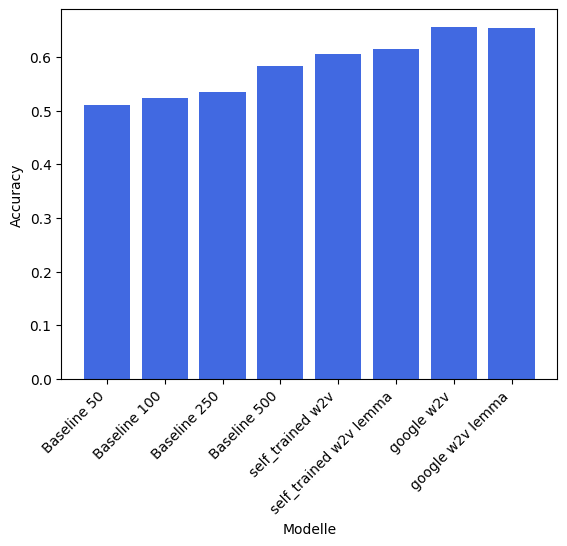

In [47]:
accs = accuracies_baseline+ [accuracy_model,accuracy_model_lemma ,accuracy_google ,accuracy_google_lemma]
len(accs)


model_names = ["Baseline 50", "Baseline 100", "Baseline 250", "Baseline 500", "self_trained w2v", "self_trained w2v lemma", "google w2v", "google w2v lemma" ]

plt.bar(model_names, accs, color="royalblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Modelle")
plt.ylabel("Accuracy")
plt.show()

Die Ergebnisse zeigen, dass das Baseline-Model besser performt, je mehr Wörter es pro Feature zur Verfügung hat. Während das beste Classifier Modell für das Basline-Model **Naive-Bayes** war, hat das Word Embedding Model mit **Support Vector Classification** am besten performt. Erwartungsgemäß, performt das Model auf Basis des Google Lexikons besser als das selbst trainierte Model. Dies liegt sehr wahrscheinlich daran, dass das Google Model viel weniger Abdeckunglücken als das eigene Model hat. Jedoch zeigt sich auch, dass das selbst trainierte Model besser performt wenn es linguistischer Features verwendet. Dagegen hat sich die Accuracy des google-basierten Models eher verschlechtert.  
  
Um die Accuracy weiter zu verbessern, ist es wohl nötig das Pre-Processing noch weiter anzupassen. Man könnte zum Beispiel eine verbesserte POS-Tagging Methode trainieren oder von Ngrams Gebrauch machen. Mit Letzteren könnte man in den Features eine Beziehung zwischen den verschiedenen Wörtern herstellen, um so die Sentiment Analyse zu verbessern. Weitere Methoden wären wohl das Anwenden von neuronalen Netzwerken, wie etwa RNNs, was jedoch den Rahmen der Vorlesung sprengen würde.